In [21]:
!pip install qrcode[pil] requests

Defaulting to user installation because normal site-packages is not writeable


In [22]:
import qrcode
from PIL import Image
from IPython.display import display
import requests
from io import BytesIO

def generate_modern_vcard(
    data,
    social_media,
    qr_color="black",
    background_color="white",
    logo_path=None,
    vcard_version="3.0",
    qr_box_size=10,
    qr_border=1
):
    """
    Generates a modern business card using X-SOCIALPROFILE fields.
    Allows vCard version selection and QR code size/border customization.
    """
    # --- 1. BUILD vCARD ---
    lines = [
        "BEGIN:VCARD",
        f"VERSION:{vcard_version}",
        f"N;CHARSET=UTF-8:{data.get('last_name', '')};{data.get('first_name', '')};;;",
        f"FN;CHARSET=UTF-8:{data.get('first_name', '')} {data.get('last_name', '')}",
        f"ORG;CHARSET=UTF-8:{data.get('organization', '')}",
        f"TITLE;CHARSET=UTF-8:{data.get('position', '')}",
        f"TEL;TYPE=CELL:{data.get('mobile', '')}",
        f"EMAIL;TYPE=WORK:{data.get('email', '')}",
        f"URL;TYPE=WORK:{data.get('website', '')}",
        f"ADR;TYPE=WORK;CHARSET=UTF-8:;;{data.get('address', '')}",
    ]
    # Add social media fields
    for platform, url in social_media.items():
        platform_lower = platform.lower()
        lines.append(f"X-SOCIALPROFILE;TYPE={platform_lower}:{url}")
    lines.append("END:VCARD")
    vcard_string = "\n".join([l for l in lines if not l.endswith(':')])
    # --- 2. GENERATE QR CODE (HIGH ERROR CORRECTION) ---
    qr = qrcode.QRCode(
        version=None,
        error_correction=qrcode.constants.ERROR_CORRECT_H, # Highest error correction (30%)
        box_size=qr_box_size,
        border=qr_border,
    )
    qr.add_data(vcard_string.encode('utf-8'))
    qr.make(fit=True)
    # --- 3. STYLE & LOGO ---
    qr_img = qr.make_image(fill_color=qr_color, back_color=background_color).convert('RGBA')
    if logo_path:
        try:
            if logo_path.startswith('http'):
                response = requests.get(logo_path)
                logo = Image.open(BytesIO(response.content))
            else:
                logo = Image.open(logo_path)
            # Scale logo
            qr_width, qr_height = qr_img.size
            logo_max_size = qr_width // 3.5
            w_percent = (logo_max_size / float(logo.size[0]))
            h_size = int((float(logo.size[1]) * float(w_percent)))
            logo = logo.resize((int(logo_max_size), h_size), Image.Resampling.LANCZOS)
            # Center logo
            pos = ((qr_width - logo.size[0]) // 2, (qr_height - logo.size[1]) // 2)
            # White background under logo for readability
            bg_logo = Image.new("RGBA", logo.size, "white")
            qr_img.paste(bg_logo, pos)
            qr_img.paste(logo, pos, logo if "A" in logo.getbands() else None)
        except Exception as e:
            print(f"Logo error: {e}")
    return qr_img, vcard_string

Logo error: cannot identify image file <_io.BytesIO object at 0x7f53d3366930>
--- BUSINESS CARD (vCard Social Profile) ---


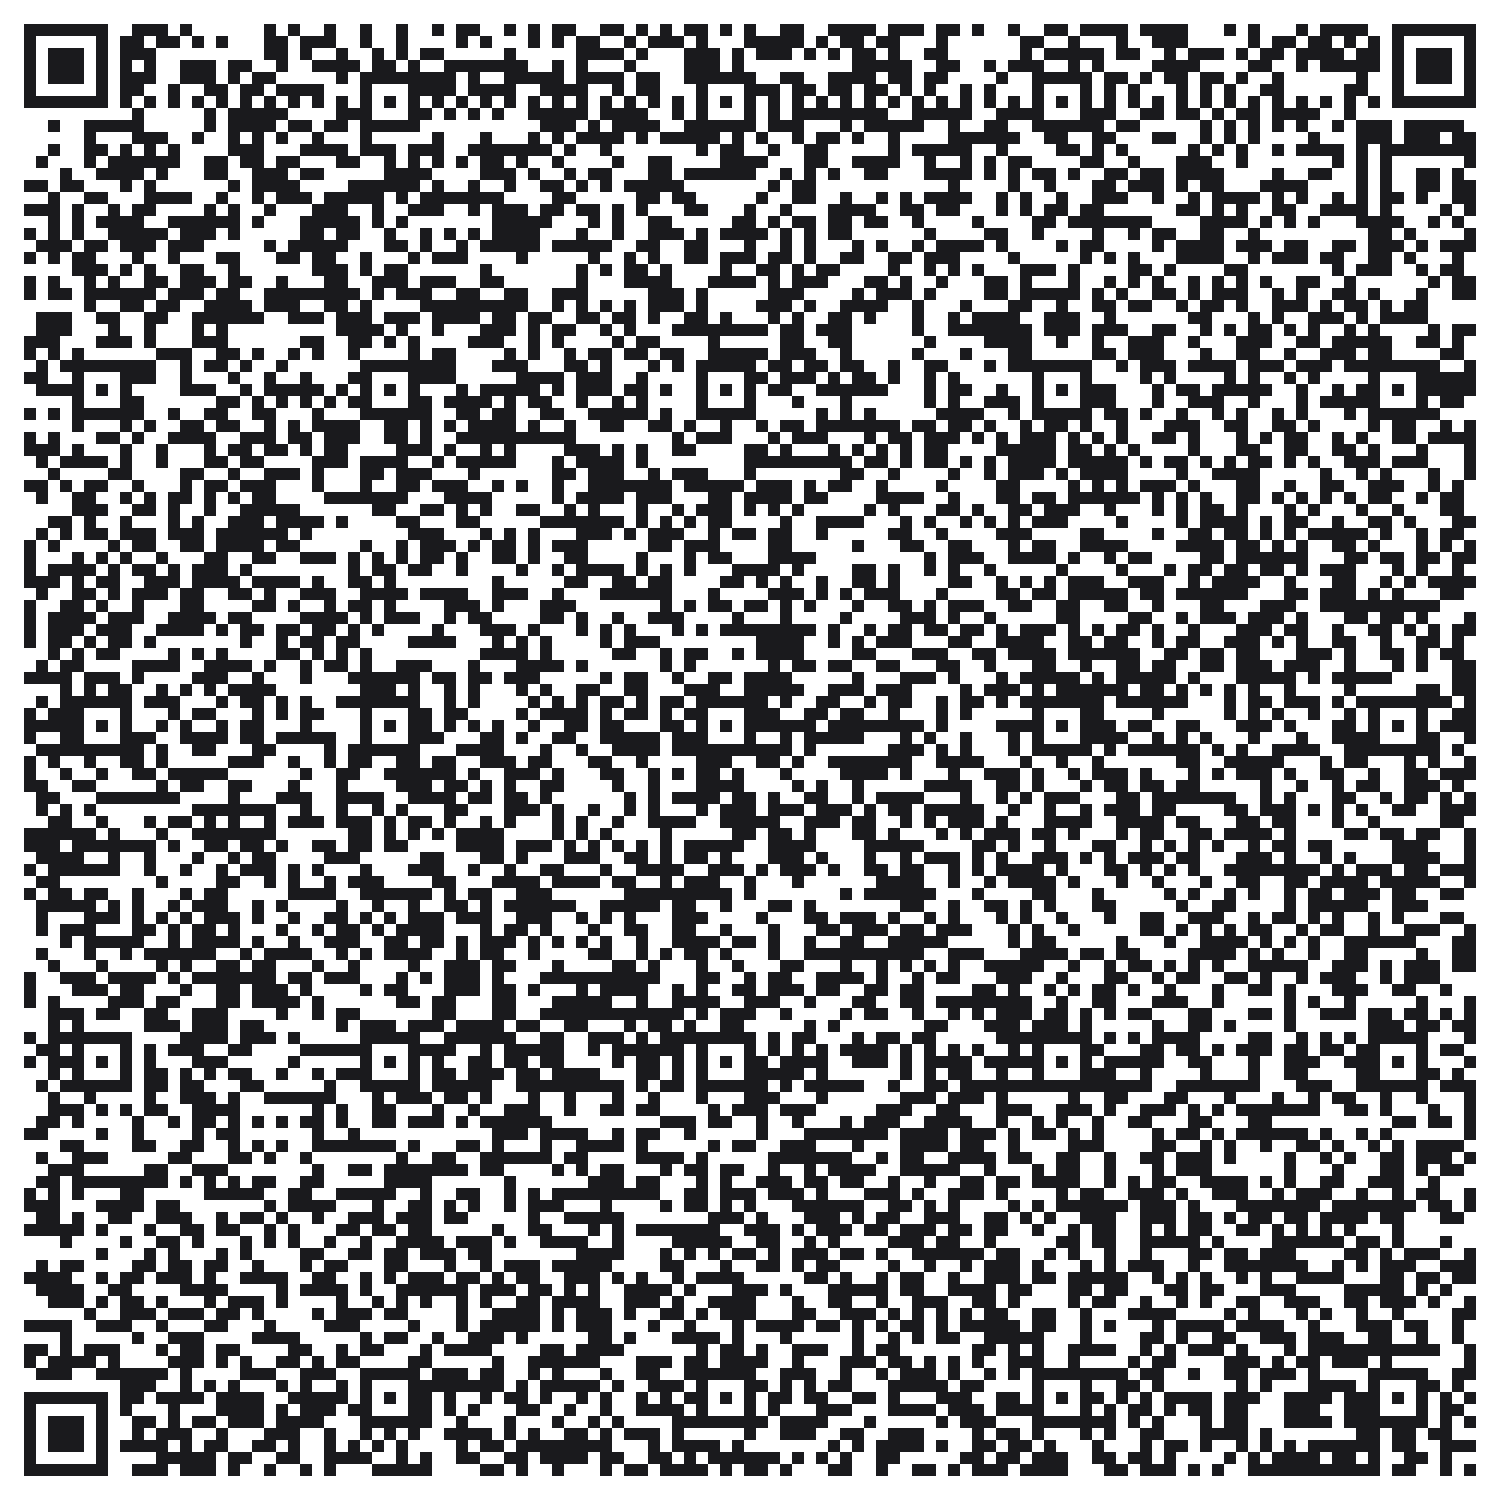

In [23]:
# --- PERSONAL DATA ---
personal_data = {
    "first_name": "Alex",
    "last_name": "Smith",
    "position": "Software Engineer",
    "organization": "Tech Innovations",
    "mobile": "+1 555 123 4567",
    "email": "alex.smith@example.com",
    "website": "https://alexsmith.dev",
    "address": "123 Main St;New York;;10001;USA"
}
# --- SOCIAL MEDIA ---
socials = {
    "linkedin": "https://www.linkedin.com/in/alexsmith",
    "twitter": "https://twitter.com/alexsmith_dev",
    "github": "https://github.com/alexsmith",
    "instagram": "https://instagram.com/alexsmith"
}
# --- DESIGN ---
# Use dark graphite color
QR_COLOR = "#1A1A1D"
# Example logo (Python logo)
LOGO = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Python-logo-notext.svg/1200px-Python-logo-notext.svg.png"
# --- GENERATE ---
# New parameters: vcard_version, qr_box_size, qr_border
img, vcard_txt = generate_modern_vcard(
    personal_data,
    socials,
    qr_color=QR_COLOR,
    logo_path=LOGO,
    vcard_version="3.0", # You can change to "4.0" if needed
    qr_box_size=12, # Larger QR code
    qr_border=2 # Thicker border
)
print("--- BUSINESS CARD (vCard Social Profile) ---")
display(img)
img.save("business_card.png")
# Export vCard to .vcf file
with open("business_card.vcf", "w", encoding="utf-8") as f:
    f.write(vcard_txt)